In [8]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import string
import re
import math
import os
import torch

In [9]:
'''
parser = argparse.ArgumentParser(description = 'MSCRED evaluation')
parser.add_argument('--thred_broken', type = int, default = 0.005,
				   help = 'broken pixel thred')
parser.add_argument('--alpha', type = int, default = 1.5,
				   help = 'scale coefficient of max valid anomaly')
parser.add_argument('--valid_start_point',  type = int, default = 8000,
						help = 'test start point')
parser.add_argument('--valid_end_point',  type = int, default = 10000,
						help = 'test end point')
parser.add_argument('--test_start_point',  type = int, default = 10000,
						help = 'test start point')
parser.add_argument('--test_end_point',  type = int, default = 20000,
						help = 'test end point')
parser.add_argument('--gap_time', type = int, default = 10,
				   help = 'gap time between each segment')
parser.add_argument('--matrix_data_path', type = str, default = './data/matrix_data/',
				   help='matrix data path')
'''       

'''
args = parser.parse_args()
print(args)

thred_b = args.thred_broken
alpha = args.alpha
gap_time = args.gap_time
valid_start = args.valid_start_point//gap_time
valid_end = args.valid_end_point//gap_time
test_start = args.test_start_point//gap_time
test_end = args.test_end_point//gap_time
'''

#thred_b = 0.005
#thred_b = 0.0052

thred_b = 0.0194

alpha = 1.5
gap_time = 10
valid_start = 8000//gap_time
valid_end = 10000//gap_time
test_start = 10000//gap_time
test_end = 20000//gap_time

valid_anomaly_score = np.zeros((valid_end - valid_start , 1))
test_anomaly_score = np.zeros((test_end - test_start, 1))

matrix_data_path = './data/matrix_data/'
test_data_path = matrix_data_path + "test_data/"
reconstructed_data_path = matrix_data_path + "reconstructed_data/"
#reconstructed_data_path = matrix_data_path + "matrix_pred_data/"
criterion = torch.nn.MSELoss()

11820

12770

12780

17800

17810

18620

18630

18640



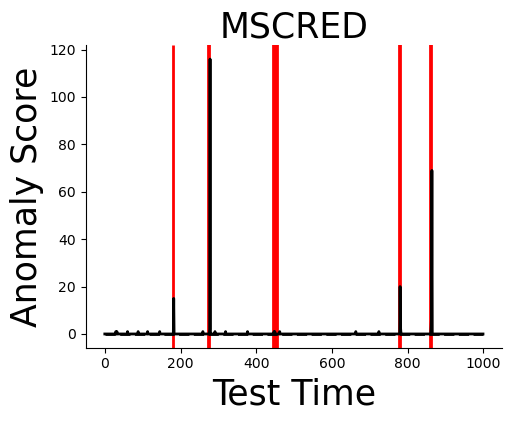

In [10]:
for i in range(valid_start, test_end):
    path_temp_1 = os.path.join(test_data_path, "test_data_" + str(i) + '.npy')
    gt_matrix_temp = np.load(path_temp_1)
    
    path_temp_2 = os.path.join(reconstructed_data_path, "reconstructed_data_" + str(i) + '.npy')
    #path_temp_2 = os.path.join(reconstructed_data_path, "pcc_matrix_full_test_" + str(i) + '_pred_output.npy')
    reconstructed_matrix_temp = np.load(path_temp_2)
    # reconstructed_matrix_temp = np.transpose(reconstructed_matrix_temp, [0, 3, 1, 2])
    #print(reconstructed_matrix_temp.shape)
    #first (short) duration scale for evaluation  
    select_gt_matrix = np.array(gt_matrix_temp)[-1][0] #get last step matrix
    
    select_reconstructed_matrix = np.array(reconstructed_matrix_temp)[0][0]
    
    #compute number of broken element in residual matrix
    select_matrix_error = np.square(np.subtract(select_gt_matrix, select_reconstructed_matrix))
    num_broken = len(select_matrix_error[select_matrix_error > thred_b])
    
    #print num_broken
    if i < valid_end:
        valid_anomaly_score[i - valid_start] = num_broken
    else:
        test_anomaly_score[i - test_start] = num_broken
         

    
        
valid_anomaly_max = np.max(valid_anomaly_score.ravel())
test_anomaly_score = test_anomaly_score.ravel()


for index, value in enumerate(test_anomaly_score):

    if value > valid_anomaly_max * alpha:
        #print(i)
        print((index + test_start) * gap_time)
        print()           

#print(test_anomaly_score)
# plot anomaly score curve and identification result
anomaly_pos = np.zeros(5)
root_cause_gt = np.zeros((5, 3))
anomaly_span = [10, 30, 90]
root_cause_f = open("../data/test_anomaly.csv", "r")
row_index = 0
for line in root_cause_f:
	line=line.strip()
	anomaly_axis = int(re.split(',',line)[0])
	anomaly_pos[row_index] = anomaly_axis/gap_time - test_start - anomaly_span[row_index%3]/gap_time
	#print(anomaly_pos[row_index])
	root_list = re.split(',',line)[1:]
	for k in range(len(root_list)-1):
		root_cause_gt[row_index][k] = int(root_list[k])
	row_index += 1
root_cause_f.close()

fig, axes = plt.subplots()
#plt.plot(test_anomaly_score, 'black', linewidth = 2)
test_num = test_end - test_start
# plt.xticks(fontsize = 25)
# plt.ylim((0, 100))
# plt.yticks(np.arange(0, 101, 20), fontsize = 25)
plt.plot(test_anomaly_score, color = 'black', linewidth = 2)

#threshold = np.full((test_num), valid_anomaly_max * alpha)
threshold = np.full((test_num), valid_anomaly_max * alpha * 0.1)

axes.plot(threshold, color = 'black', linestyle = '--',linewidth = 2)
for k in range(len(anomaly_pos)):
	axes.axvspan(anomaly_pos[k], anomaly_pos[k] + anomaly_span[k%3]/gap_time, color='red', linewidth=2)
labels = [' ', '0e3', '2e3', '4e3', '6e3', '8e3', '10e3']
# axes.set_xticklabels(labels, rotation = 25, fontsize = 20)
plt.xlabel('Test Time', fontsize = 25)
plt.ylabel('Anomaly Score', fontsize = 25)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.yaxis.set_ticks_position('left')
axes.xaxis.set_ticks_position('bottom')
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(left=0.25)
plt.title("MSCRED", size = 25)
plt.savefig('./outputs/anomaly_score.jpg')
plt.show()
